<a href="https://colab.research.google.com/github/franitaa/ADHD-EEG-Game/blob/main/ADHD_EEG_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de ADHD a través de un juego basado en EEG

*   Francesca Rondinella (61031)
*   Nicolás Suárez Durrels (62468)


## Dudas + Ideas

- En vez de hacer un espectrograma, hacer un histograma.
- Otras features que podemos usar, que son usuales en análisis de EEG, son: dimensión fractal, ICA, FFT, Wavelet Transform.

## Imports y carga de datos

Como primer paso se importan todas las bibliotecas relevantes para el proyecto, y se importan los datos en formato csv a diccionarios, para posteriormente tratarlos como dataframes.

El dataset consta de dos carpetas que dividen a los sujetos en ADHD y no-ADHD, y cada persona tiene una carpeta de registros durante el juego controlado por BCI ("Emotiv") y por teclado ("Keyboard"). El grupo de control tiene, además de las bandas de frecuencia, las señales crudas. Estas se desestimaron ya que al no estar disponibles para el grupo ADHD, no se podían utilizar para realizar un análisis comparativo. Fueron útiles, sin embargo, para el cálculo de la frecuencia de muestreo.

A través de los timestamps que se hallan en las señales crudas se dedujo que la frecuencia de muestreo es de 125 Hz. En el paper se menciona el uso de ventanas sin solapamiento de tamaño 5 (sin especificación de unidades de medida) para la división en bandas de frecuencia. El investigador Shervin Shirmohamma confirmó que se trata de ventanas de 5 muestras, es decir que la frecuencia "neta" sería de 125/5=25 Hz.

Finalmente, a raíz de lo que se realizó durante la investigación, se agregaron cuatro columnas que relacionan las distintas bandas de frecuencia: theta/high beta, theta/low beta, alpha/high beta y alpha/low/beta.

In [ ]:
pip install umap-learn

In [ ]:
#Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram
from sklearn.manifold import TSNE
from umap import UMAP
import random
import re

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
main_folder_path = '/content/drive/MyDrive/New EEG Data'

# diccionarios
adhd_emotive = {}
adhd_keyboard = {}
non_adhd_emotive = {}
non_adhd_keyboard = {}

def read_and_categorize_csv_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # categoria segun path
                relative_path = os.path.relpath(file_path, main_folder_path)
                parts = relative_path.split(os.sep)

                if len(parts) >= 3:
                    category = parts[0]  # ADHD o Non-ADHD
                    subcategory = parts[2]  # Emotive o Keyboard

                    #df = pd.read_csv(file_path)
                    df = pd.read_csv(file_path, index_col=False).dropna(how='all')

                    #selected_columns = ['Theta', ' Alpha', ' Low_beta', ' High_beta', ' Gamma ']
                    #filtered_df  = df[selected_columns]
                    # Strip leading/trailing spaces from column names
                    df.columns = df.columns.str.strip()
                    #print("Available columns:", df.columns.tolist())
                    #print(parts)

                    selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

                    if all(column in df.columns for column in selected_columns):
                      filtered_df  = df[selected_columns]

                      # Replace 0s with NaN to avoid division by zero
                      filtered_df.replace(0, np.nan, inplace=True)

                      # Add the new columns
                      filtered_df['Theta/High_beta'] = filtered_df['Theta'] / filtered_df['High_beta']
                      filtered_df['Theta/Low_beta'] = filtered_df['Theta'] / filtered_df['Low_beta']
                      filtered_df['Alpha/High_beta'] = filtered_df['Alpha'] / filtered_df['High_beta']
                      filtered_df['Alpha/Low_beta'] = filtered_df['Alpha'] / filtered_df['Low_beta']

                      # Fill NaN values back to 0 if necessary (optional)
                      filtered_df.fillna(0, inplace=True)

                      if category == 'ADHD' and subcategory == 'Emotiv':
                          adhd_emotive[relative_path] = filtered_df
                      elif category == 'ADHD' and subcategory == 'Keyboard':
                          adhd_keyboard[relative_path] = filtered_df
                      elif category == 'Non-ADHD' and subcategory == 'Emotive':
                          non_adhd_emotive[relative_path] = filtered_df
                      elif category == 'Non-ADHD' and subcategory == 'Keyboard':
                          non_adhd_keyboard[relative_path] = filtered_df




read_and_categorize_csv_files(main_folder_path)

print("ADHD - Emotive:", adhd_emotive.keys())
print("ADHD - Keyboard:", adhd_keyboard.keys())
print("Non-ADHD - Emotive:", non_adhd_emotive.keys())
print("Non-ADHD - Keyboard:", non_adhd_keyboard.keys())


        Theta      Alpha   Low_beta  High_beta      Gamma  Theta/High_beta  \
0  144.090564  47.345218  33.950422  25.645022  17.375215         5.618656   
1  164.162214  52.095417  31.797823  18.833161  12.683386         8.716657   
2  146.320972  41.021074  21.254120  13.090643   4.860802        11.177524   
3  135.365645  39.000685  21.691576  14.378104  14.551685         9.414707   
4  140.392667  42.540855  26.807940  18.032869   9.527630         7.785376   

   Theta/Low_beta  Alpha/High_beta  Alpha/Low_beta  
0        4.244147         1.846176        1.394540  
1        5.162687         2.766154        1.638333  
2        6.884358         3.133618        1.930029  
3        6.240471         2.712505        1.797965  
4        5.236981         2.359073        1.586875  
        Theta      Alpha   Low_beta  High_beta      Gamma  Theta/High_beta  \
0   93.189913  32.617904  16.770203   9.119981   4.839002        10.218214   
1  108.141929  39.639471  23.753960  15.019328  10.733314

In [40]:
# Combina todos los dataframes
def combine_data(data_dict):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    return combined_df


combined_adhd_emotive = combine_data(adhd_emotive)
combined_adhd_keyboard = combine_data(adhd_keyboard)
combined_non_adhd_emotive = combine_data(non_adhd_emotive)
combined_non_adhd_keyboard = combine_data(non_adhd_keyboard)


combined_adhd_emotive['Label'] = 'ADHD_emotive'
combined_adhd_keyboard['Label'] = 'ADHD_keyboard'
combined_non_adhd_emotive['Label'] = 'Non_ADHD_emotive'
combined_non_adhd_keyboard['Label'] = 'Non_ADHD_keyboard'

# Por ahora estamos trabajando solo con emotive
combined_data = pd.concat([combined_adhd_emotive,
                           combined_non_adhd_emotive])

features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma', 'Theta/High_beta', 'Theta/Low_beta', 'Alpha/High_beta', 'Alpha/Low_beta']
x = combined_data[features]
y = combined_data['Label']

# TODO fijarse si hay mejor forma de sacar outliers
z_scores = np.abs((x - x.mean()) / x.std())
x = x[(z_scores < 3).all(axis=1)]
y = y[(z_scores < 3).all(axis=1)]
# Estandarizamos
x = StandardScaler().fit_transform(x)
print(y)

0             ADHD_emotive
1             ADHD_emotive
2             ADHD_emotive
3             ADHD_emotive
4             ADHD_emotive
                ...       
103660    Non_ADHD_emotive
103661    Non_ADHD_emotive
103662    Non_ADHD_emotive
103663    Non_ADHD_emotive
103664    Non_ADHD_emotive
Name: Label, Length: 179614, dtype: object


In [41]:
# Combino num_samples de adhd y non adhd. Termino con num_samples*2 totales
# También marco en y_subset non adhd y a los adhd los diferencio por paciente
num_samples = 35000


adhd_df_list = []
for key, df in adhd_emotive.items():
    adhd_number = re.search(r'ADHD/(\d+)/', key).group(1)

    df['Label'] = f"ADHD_{adhd_number}"
    adhd_df_list.append(df)
combined_adhd_emotive = pd.concat(adhd_df_list, ignore_index=True)


non_adhd_df_list = []
for key, df in non_adhd_emotive.items():
    df['Label'] = 'Non_ADHD'
    non_adhd_df_list.append(df)
combined_non_adhd_emotive = pd.concat(non_adhd_df_list, ignore_index=True)

# features
features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma', 'Theta/High_beta', 'Theta/Low_beta', 'Alpha/High_beta', 'Alpha/Low_beta']

# Estandarizar
scaler = StandardScaler()
x_adhd = scaler.fit_transform(combined_adhd_emotive[features])
x_non_adhd = scaler.fit_transform(combined_non_adhd_emotive[features])

# Labels
y_adhd = combined_adhd_emotive['Label']
y_non_adhd = combined_non_adhd_emotive['Label']

# TODO: agarrar la misma cantidad de cada uno de los adhd. Ahora mismo agarra random, pero como tienen diferente tamaño
# Terminamos analizando diferentes proporciones de los adhd
random.seed(42)
adhd_indices = random.sample(range(len(x_adhd)), num_samples)
non_adhd_indices = random.sample(range(len(x_non_adhd)), num_samples)

x_subset = np.concatenate((x_adhd[adhd_indices], x_non_adhd[non_adhd_indices]), axis=0)
y_subset = pd.concat([y_adhd.iloc[adhd_indices].reset_index(drop=True),
                      y_non_adhd.iloc[non_adhd_indices].reset_index(drop=True)])
print(y_subset.value_counts())



Label
Non_ADHD    35000
ADHD_7      13003
ADHD_10      9526
ADHD_8       9109
ADHD_9       3362
Name: count, dtype: int64


## Análisis preliminar de los datos

En esta sección, como el dataset ya ha sido pre-procesado y dividido en bandas de frecuencia se realizan directamente técnicas de reducción de dimensionalidad para sacar conclusiones acerca de las componentes más relevantes del problema.

### Ploteo

En principio se plotean dos señales aleatorias a modo de ejemplo, de cada clase de sujeto. Se observan diferencias sustanciales en la amplitud, especialmente de los ritmos theta.


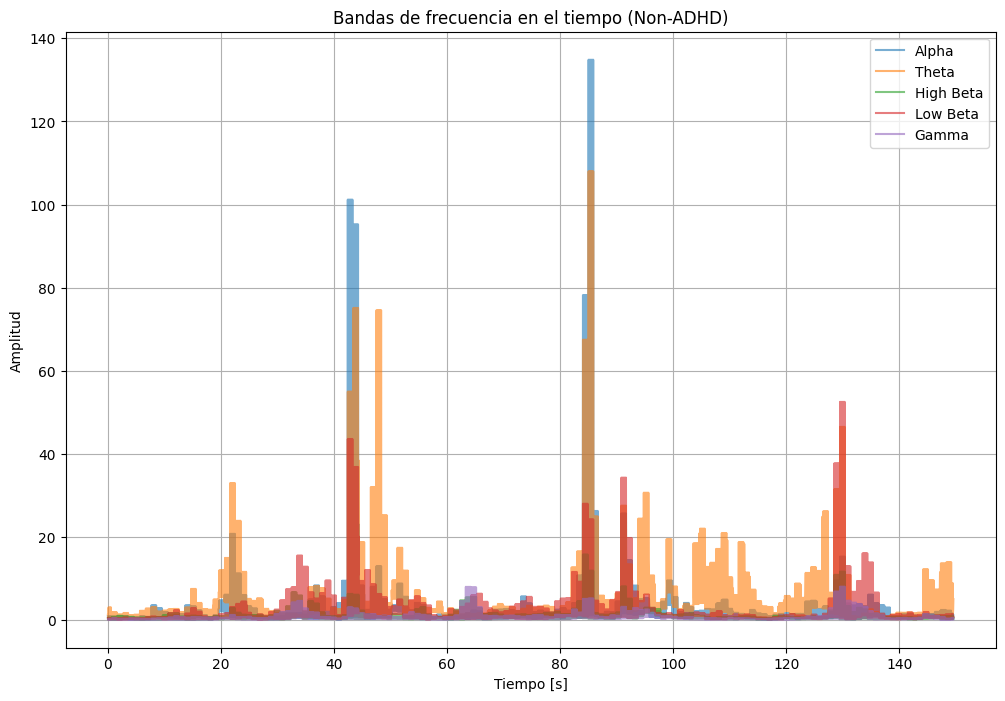

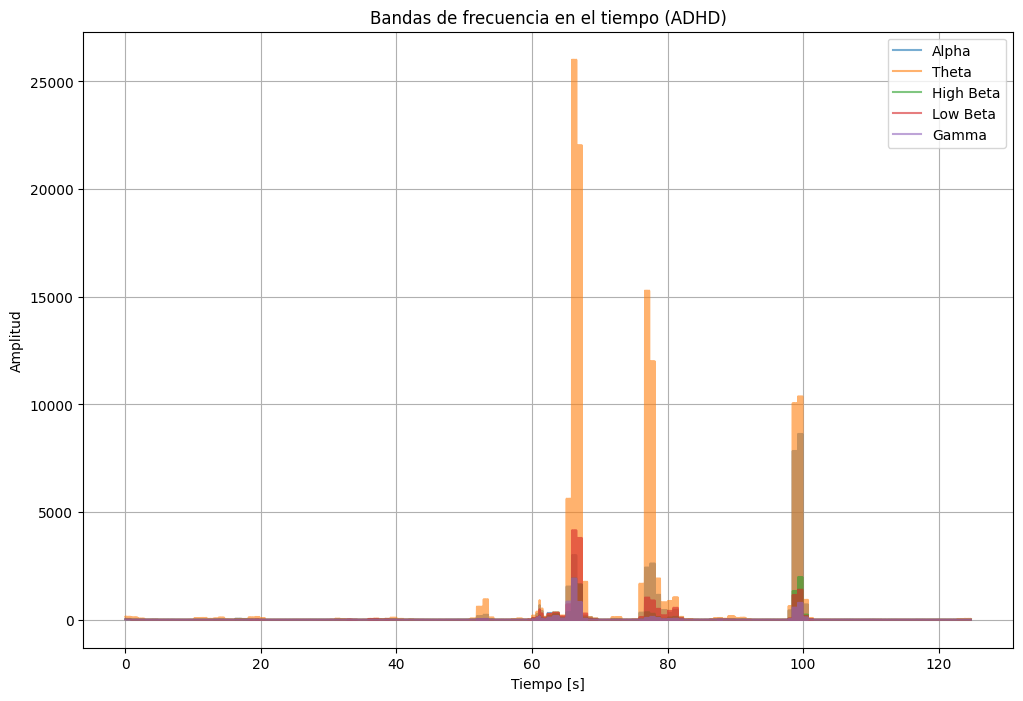

In [42]:
values = non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv']
values2 = adhd_emotive['ADHD/10/Emotiv/emo zeynep 5.csv']

alpha = values['Alpha']
theta = values['Theta']
high_beta = values['High_beta']
low_beta = values['Low_beta']
gamma = values['Gamma']


fs = 125/5
t = values.index / fs

plt.figure(figsize=(12, 8))

plt.plot(t, alpha, label='Alpha', alpha=0.6)
plt.plot(t, theta, label='Theta', alpha=0.6)
plt.plot(t, high_beta, label='High Beta', alpha=0.6)
plt.plot(t, low_beta, label='Low Beta', alpha=0.6)
plt.plot(t, gamma, label='Gamma', alpha=0.6)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (Non-ADHD)')
plt.legend()
plt.grid(True)

plt.show()

alpha2 = values2['Alpha']
theta2 = values2['Theta']
high_beta2 = values2['High_beta']
low_beta2 = values2['Low_beta']
gamma2 = values2['Gamma']

t = values2.index / fs


plt.figure(figsize=(12, 8))

plt.plot(t, alpha2, label='Alpha', alpha=0.6)
plt.plot(t, theta2, label='Theta', alpha=0.6)
plt.plot(t, high_beta2, label='High Beta', alpha=0.6)
plt.plot(t, low_beta2, label='Low Beta', alpha=0.6)
plt.plot(t, gamma2, label='Gamma', alpha=0.6)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (ADHD)')
plt.legend()
plt.grid(True)

plt.show()

### Espectrogramas

Debido a que las señales ya han sido divididas en sus respectivas bandas de frecuencia, lo que no permite una reconstrucción fidedigna de los datos originales, no es posible realizar un espectrograma.

### Histogramas

### PCA

In [46]:
pca_model = PCA()
pca_zscore = pca_model.fit_transform(x)
explained_variance_ratio = pca_model.explained_variance_ratio_

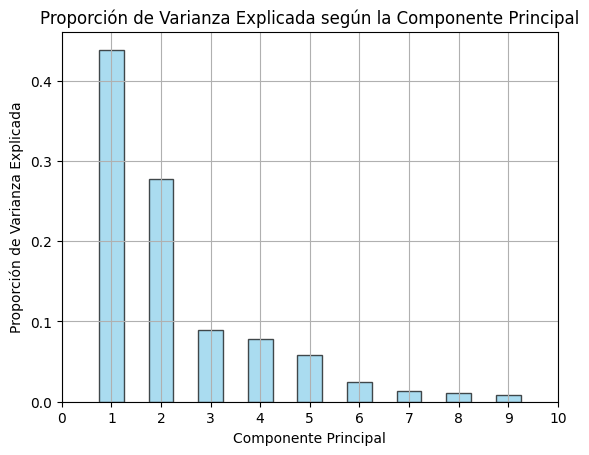

In [47]:
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='skyblue', width=0.5, edgecolor='black', alpha=0.7)
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Proporción de Varianza Explicada según la Componente Principal')
plt.xlim(0, 10)
plt.xticks(range(0, 11))
plt.grid(True)
plt.show()

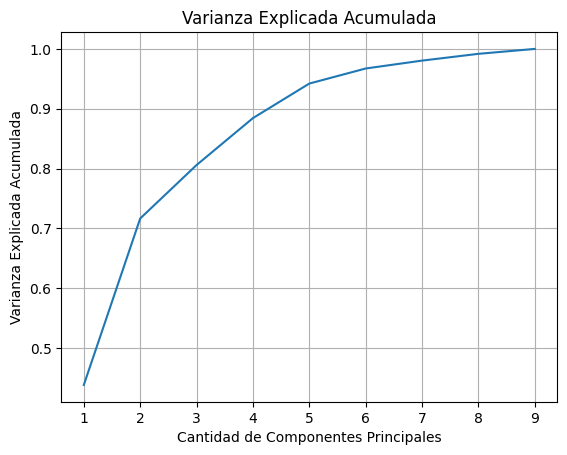

In [48]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Cantidad de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

Con tres componentes se alcanza una varianza explicada acumulada del 80%.

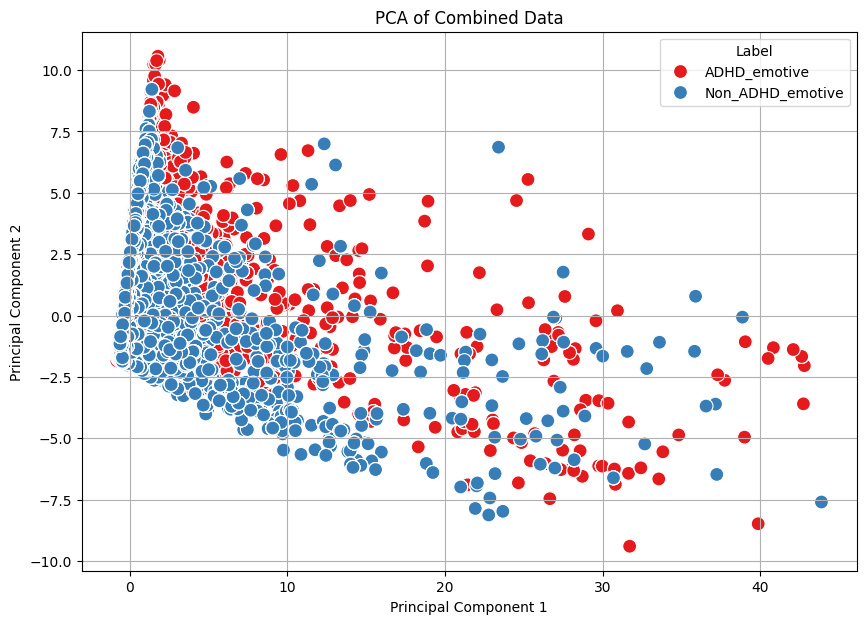

In [57]:
principal_components = pca_model.fit_transform(x)

principal_df = pd.DataFrame(data=pca_zscore, columns=[f'principal_component_{i+1}' for i in range(9)])

final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)


plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df, x='principal_component_1', y='principal_component_2', hue='Label', palette='Set1', s=100)
plt.title('PCA of Combined Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

La separación entre los dos grupos a través de PCA no es buena.

### LDA

Por lo que entendemos, LDA puede graficar en una dimensión en nuestro caso. Toma el mínimo entre las features (5) y la cantidad de clases - 1 (si tomamos solo ADHD vs non-ADHD, es 1). Si hago este grafico con histograma no llego a nada lindo, porque los dos grupos concentran sus datos en casi el mismo lugar.

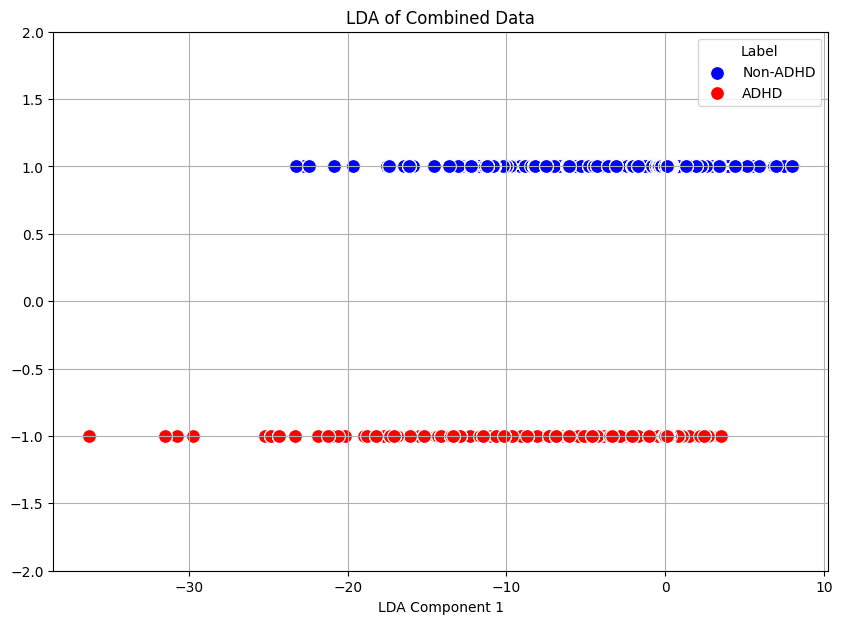

LDA coefficients:
[[-0.15049549  0.0452969   0.0857798  -0.20740394  0.09700832]]

Explained variance ratio:
[1.]


In [ ]:
lda = LDA(n_components=1)

lda_components = lda.fit_transform(x, y)

lda_df = pd.DataFrame(data=lda_components, columns=['lda_component_1'])

final_df = pd.concat([lda_df, y.reset_index(drop=True)], axis=1)

# Separo en base a label
non_adhd_data = final_df[final_df['Label'] == 'Non_ADHD_emotive']
adhd_data = final_df[final_df['Label'] == 'ADHD_emotive']

plt.figure(figsize=(10, 7))

sns.scatterplot(data=non_adhd_data, x='lda_component_1', y=np.ones(len(non_adhd_data)), color='blue', label='Non-ADHD', s=100)

sns.scatterplot(data=adhd_data, x='lda_component_1', y=-np.ones(len(adhd_data)), color='red', label='ADHD', s=100)

plt.title('LDA of Combined Data')
plt.xlabel('LDA Component 1')
plt.ylabel('')
plt.ylim(-2, 2)  # Hay outliers lejanos
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

print("LDA coefficients:")
print(lda.coef_)

explained_variance_ratio = lda.explained_variance_ratio_
print("\nExplained variance ratio:")
print(explained_variance_ratio)

### t-SNE

Por ahora estamos trabajando con subsets, ya que al trabajar con toda la data tarda demasiado. De todas formas, podemos ver que los datos se agrupan de acuerdo a ADHD y sin ADHD. Utilizando diferentes colores para los datos de cada sujeto con ADHD, también se puede observar que estos se agrupan según la persona. Los datos del sujeto 7 son los mas cercanos a los datos sin ADHD.


La idea de colorear los distintos sujetos de ADHD nace a partir de la voluntad de diferenciar a la persona que recibió tratamiento. En el paper se la nombra como P2 y sospechamos que se trata del sujeto 8, pero no estamos seguros ya que no se explicita en cuanto al dataset. Queremos comunicarnos con los investigadores para saber si nos lo pueden decir.

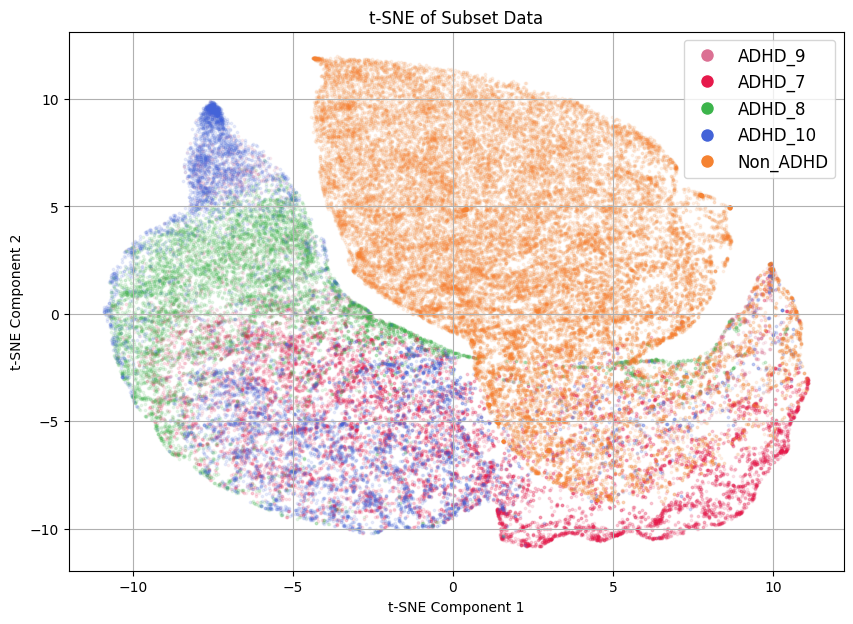

In [ ]:

tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=350
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

y_concatenated = pd.concat([y[:subset_size_each].reset_index(drop=True), y[-subset_size_each:].reset_index(drop=True)])
final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
tsne_model = TSNE(
    n_components=2,
    perplexity=250,
    learning_rate=200,
    n_iter=550
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

### UMAP

Similarmente a t-SNE podemos ver que llegamos a un resultado prometedor. Por un lado tenemos a la mayoria de los puntos sin ADHD, mientras que en el otro lado tenemos a la mayoria de los puntos con ADHD. TODO check si es correcto agregarle ruido, ya que me lo pide al utilizar verbose.

<bound method DataFrame.info of        umap_component_1  umap_component_2
0              6.941781         14.199130
1              7.051848          9.136665
2             10.470878          9.973435
3              8.841610         10.658135
4              0.789802          7.921194
...                 ...               ...
69995         12.663960          2.633303
69996         10.523225          3.200865
69997         12.139360         -5.328474
69998          8.419874         14.071481
69999         13.168877          1.822857

[70000 rows x 2 columns]>
<bound method DataFrame.info of        umap_component_1  umap_component_2     Label
0              6.941781         14.199130    ADHD_9
1              7.051848          9.136665    ADHD_7
2             10.470878          9.973435    ADHD_7
3              8.841610         10.658135    ADHD_8
4              0.789802          7.921194    ADHD_8
...                 ...               ...       ...
69995         12.663960          2.633303

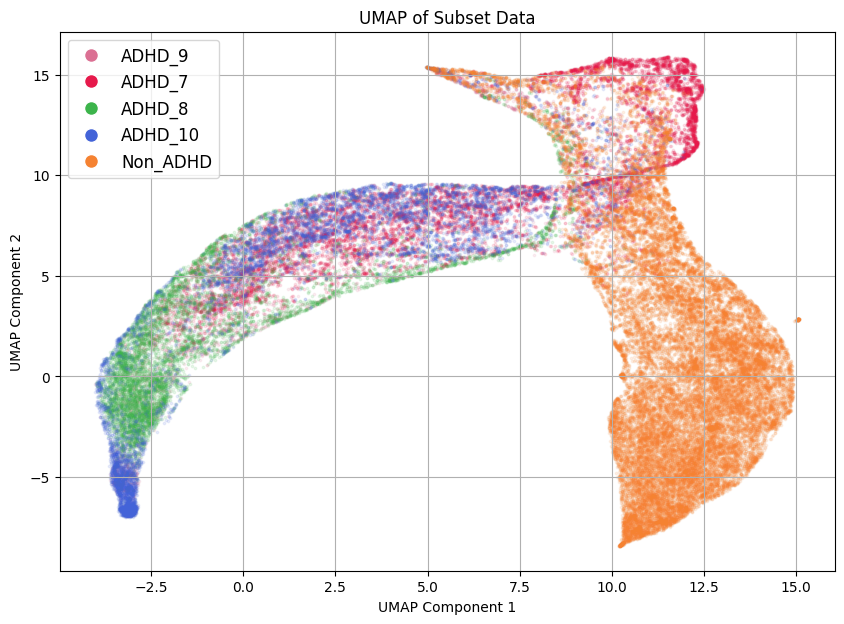

In [ ]:

noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=150,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])
print(umap_df.info)

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)

print(final_df_umap.info)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

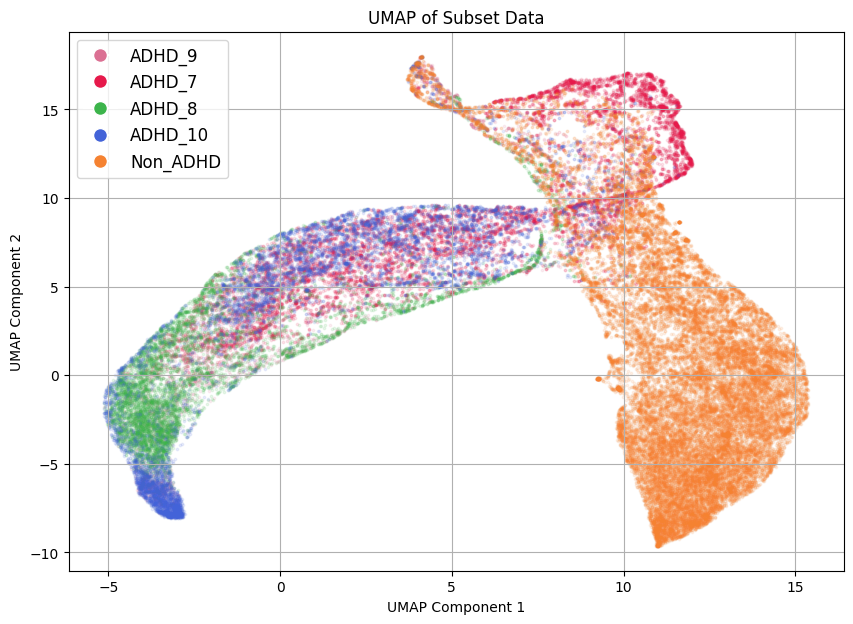

In [ ]:
noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)


color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

### Conclusiones acerca de los datos

La separación en los dos grupos a clasificar es buena para UMAP y t-SNE, no así para los métodos de PCA y LDA.

## Clasificación